In [14]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision
from torchvision import models
from functools import partial
import csv
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import cv2

In [15]:
label_to_text_RAF = {1:"Surprise", 2:"Fear", 3:"Disgust", 4:"Happiness", 5:"Sadness", 6:"Anger", 7:"Neutral"}

label_to_text_FER = {0:'Neutral',1:'Happiness',2:'Surprise',3:'Sadness',4:'Anger',5:'Disgust',6:'Fear',7:'Contempt'}

In [16]:
class ToTensor(object):
    
    def __call__(self, sample):
        image, label, img_name, mode = sample['Image'], sample['Label'], sample['ImgName'], sample['Mode']
        
        image = np.expand_dims(image, axis=0)
        
        return {'Image': torch.from_numpy(image).float(), 'Label':label, 'ImgName':img_name, 'Mode':mode}

In [17]:
class RAF(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        
        df = pd.read_csv(csv_file, header=None, names=['column1'])
        df[['filename', 'label']] = df['column1'].str.split(' ', 1, expand=True)
        
        self.ImgNames = df.drop('column1', axis=1)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.ImgNames)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.ImgNames.iloc[idx, 0])   
        img_name = img_name.replace(".jpg", "")
        img_name = img_name + "_aligned" + ".jpg"
        label = self.ImgNames.iloc[idx , 1]
        label = int(label[0])-1
        
        image = Image.open(img_name).resize((48,48)).convert('L')
        image= np.array(image)
        
        
        mode = ""
        if self.ImgNames.iloc[idx, 0].startswith("train"):
            mode = "train"
        if self.ImgNames.iloc[idx, 0].startswith("test"):
            mode = "test"
        
        
        train_transform = transforms.Compose([
            transforms.RandomCrop(44),
            transforms.RandomRotation(degrees=(-25, 25)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()])
        
        
        sample = {'Image':image, 'Label':label, 'ImgName':img_name, "Mode":mode}
        
        if self.transform:
            sample = self.transform(sample)
            sample["Image"]  = train_transform(sample["Image"])

            
        return sample

In [18]:
transformed_dataset = RAF(csv_file='./RAF/list_patition_label.txt',
                                    root_dir='./RAF',
                                      transform=transforms.Compose([ToTensor()]))

C:\Users\moqixiang927\AppData\Local\Temp\ipykernel_1536\2058092255.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['filename', 'label']] = df['column1'].str.split(' ', 1, expand=True)


0 torch.Size([1, 44, 44]) 4 ./RAF\train_00001_aligned.jpg
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


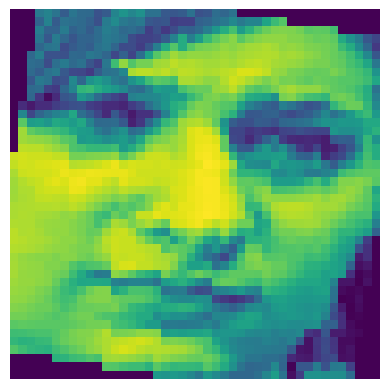

torch.Size([44, 44, 1])
1 torch.Size([1, 44, 44]) 4 ./RAF\train_00002_aligned.jpg
tensor([[[ 24.,  22.,  24.,  ...,  48.,  35.,  30.],
         [ 26.,  29.,  36.,  ...,  83.,  36.,  52.],
         [ 23.,  32.,  48.,  ..., 102.,  68.,  60.],
         ...,
         [ 46.,  44.,  53.,  ...,  70., 102., 140.],
         [ 46.,  52.,  55.,  ...,  94., 124., 139.],
         [ 37.,  42.,  34.,  ..., 112., 127., 126.]]])


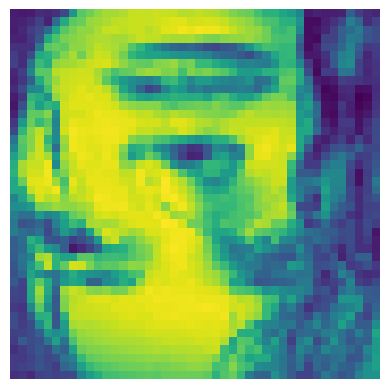

torch.Size([44, 44, 1])
2 torch.Size([1, 44, 44]) 3 ./RAF\train_00003_aligned.jpg
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


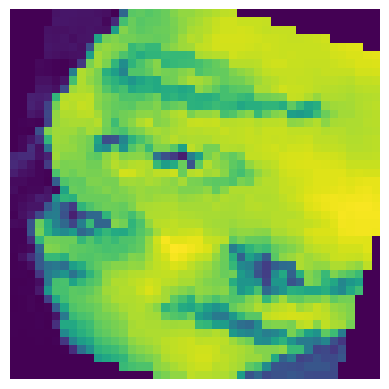

torch.Size([44, 44, 1])
3 torch.Size([1, 44, 44]) 3 ./RAF\train_00004_aligned.jpg
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


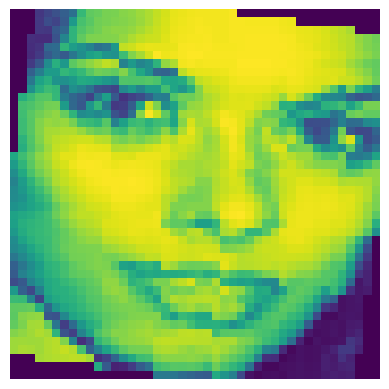

torch.Size([44, 44, 1])


In [19]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['Image'].size(), sample['Label'], sample['ImgName'])
    print(sample['Image'])
    img = np.transpose(sample['Image'], (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')  # Optional: Hide axis ticks and labels
    plt.show()
    print(img.size())
    abc = sample['Image']
    if i == 3:
        break

In [20]:
label_counts = {}
label_to_text_RAF = {1:"Surprise", 2:"Fear", 3:"Disgust", 4:"Happiness", 5:"Sadness", 6:"Anger", 7:"Neutral"}
label_to_text_RAF = {0:"Surprise", 1:"Fear", 2:"Disgust", 3:"Happiness", 4:"Sadness", 5:"Anger", 6:"Neutral"}

label_to_text_FER = {0:'Neutral',1:'Happiness',2:'Surprise',3:'Sadness',4:'Anger',5:'Disgust',6:'Fear',7:'Contempt'}

for idx in range(len(transformed_dataset)):
    sample = transformed_dataset[idx]
    label = sample['Label']

    # Increment the count for the label in the dictionary
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1
        
label_counts_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])
label_counts_df

,Label,Count
0,4,2460
1,3,5957
2,0,1619
3,5,867
4,1,355
5,2,877
6,6,3204


In [21]:
def raf_to_fer(input_label):
    label_to_text_RAF = {0:"Surprise", 1:"Fear", 2:"Disgust", 3:"Happiness", 4:"Sadness", 5:"Anger", 6:"Neutral"}
    label_to_text_FER = {0:'Neutral',1:'Happiness',2:'Surprise',3:'Sadness',4:'Anger',5:'Disgust',6:'Fear',7:'Contempt'}
    output_label = ""
    
    text = label_to_text_RAF[input_label]
    
    for key,value in label_to_text_FER.items():
        if value == text:
            output_label =  key
    
    return output_label


In [22]:
def save_to_csv(data, file_path):
    headers = ["Image name", "Label"]
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(data)

In [23]:
df = pd.read_csv('./RAF/list_patition_label.txt', header=None, names=['column1'])
df[['filename', 'label']] = df['column1'].str.split(' ', 1, expand=True)
df = df.drop('column1', axis=1)

C:\Users\moqixiang927\AppData\Local\Temp\ipykernel_1536\2521546786.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['filename', 'label']] = df['column1'].str.split(' ', 1, expand=True)


In [24]:
df

,filename,label
0,train_00001.jpg,5
1,train_00002.jpg,5
2,train_00003.jpg,4
3,train_00004.jpg,4
4,train_00005.jpg,5
...,...,...
15334,test_3064.jpg,7
15335,test_3065.jpg,7
15336,test_3066.jpg,7
15337,test_3067.jpg,7


In [25]:
root_dir='./RAF/'
headers = ["Image name", "Label"]
label_4_info = []
label_5_info = []
label_6_info = []


for idx in range(len(df)):
    
    img_path = os.path.join(root_dir, df.iloc[idx, 0])
    img_path = img_path.replace(".jpg", "")
    img_path = img_path + "_aligned" + ".jpg"
    
    label = df.iloc[idx , 1]
    label = int(label[0])-1
    label = raf_to_fer(label)
    
    image = Image.open(img_path).resize((48,48)).convert('L')
    image= np.array(image)
    
    output_path = 'D:/Leaning in Glasgow/Msc Project/DATA/extra/RAF' 
    
    csv_file_path_4 = "D:/Leaning in Glasgow/Msc Project/DATA/extra/RAF/label4/label4.csv"
    csv_file_path_5 = "D:/Leaning in Glasgow/Msc Project/DATA/extra/RAF/label5/label5.csv"
    csv_file_path_6 = "D:/Leaning in Glasgow/Msc Project/DATA/extra/RAF/label6/label6.csv"
    
    if label == 4:
        filename = str(idx) + '.jpg'
        file_path = output_path + '/label4/' + filename
        cv2.imwrite(file_path, image)
        label_4_info.append([filename, 4])
        
    if label == 5:
        filename = str(idx) + '.jpg'
        file_path = output_path + '/label5/' + filename
        cv2.imwrite(file_path, image)
        label_5_info.append([filename, 5])
        
    if label == 6:
        filename = str(idx) + '.jpg'
        file_path = output_path + '/label6/' + filename
        cv2.imwrite(file_path, image)
        label_6_info.append([filename, 6])
    
save_to_csv(label_5_info, csv_file_path_5)
save_to_csv(label_6_info, csv_file_path_6)  
save_to_csv(label_4_info, csv_file_path_4)  